# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification Challenge

The task involves developing a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset provided contains 43,943 tweets collected between April 27, 2015, and February 21, 2018. Each tweet is labeled with one of four classes: News, Pro, Neutral, or Anti, representing different perspectives on climate change.
Your company has been awarded the contract to:

 1. Analyse the supplied data;
 2. Clean and transform data, including removing noise, handling missing values, and applying text preprocessing techniques like tokenization, stop-word removal, and stemming or lemmatization;
 3. Extract relevant features from the tweet data that can contribute to the classification task;
 4. Choose an appropriate Machine Learning algorithm for the classification task;
 5. Train the model and evaluate using appropriate evaluation metrics such as accuracy, precision, recall, and F1 score;
 6. Deploy to classify new, unseen tweets into the belief classes, and
 7. Explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model this classification problem, by exploring and preprocessing the data, perform feature engineering, and train a suitable Machine Learning model. The model will learn from the labeled tweets to classify new, unseen tweets into one of the belief classes accurately. The goal is to create a robust and accurate model that can provide valuable insights into people's perceptions of climate change.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents
<a href=#one>1. Introduction</a>

<a href=#two>2. Problem Statement</a>

<a href=#three>3. Importing Packages</a>

<a href=#four>4. Loading Data</a>

<a href=#five>5. Exploratory Data Analysis (EDA)</a>

<a href=#six>6. Data Engineering</a>

<a href=#seven>7. Modeling</a>

<a href=#eight>8. Model Performance</a>

<a href=#nine>9. Model Explanations</a>

<a href=#ten>10. Conclusion</a>

<a href=#eleven>11. References</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In today's world, climate change is a pressing global issue that has gained significant attention. Many companies are dedicated to reducing environmental impact and carbon footprints by offering sustainable and environmentally friendly products and services. To gauge public sentiment and understand how their offerings may be received, these companies require insights into people's beliefs regarding climate change.


 <a id="two"></a>
## 2. Problem Statement
<a href=#cont>Back to Table of Contents</a>

Develop a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset includes 43,943 tweets collected between April 27, 2015, and February 21, 2018, labeled with four classes:

- News: The tweet links to factual news about climate change.
- Pro: The tweet supports the belief of man-made climate change.
- Neutral: The tweet neither supports nor refutes the belief of man-made climate change.
- Anti: The tweet does not believe in man-made climate change.

The objective is to create an accurate and robust model that can provide insights into public sentiment on climate change, aiding companies in understanding the reception of their environmentally friendly products and services for informed marketing strategies.

 <a id="three"></a>
## 3. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [67]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re

# Libraries for data preparation and model building
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
import time
import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import urllib
# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###
# set plot style
sns.set()

<a id="four"></a>
## 4. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [45]:
# load the data
train = pd.read_csv('../resources/data/train.csv')
test = pd.read_csv('../resources/data/test_with_no_labels.csv')

<a id="five"></a>
## 5. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


**Checking the shape of the training and testing data**

In [46]:
#Training data
print(train.shape)
#Testing data
print(test.shape)

(15819, 3)
(10546, 2)


**Observation:**

The training set have three features and the testing set has two features.
The Training set has 15819 observations and the testing set has 10546 Observations


In [47]:
# Reading the first 5 rows of the train data
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [48]:
# Reading the first 5 rows of test data
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [49]:
# Checking for the datatypes, null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [50]:
# Checking the sum of null values
train.isnull().sum()


sentiment    0
message      0
tweetid      0
dtype: int64

**Observations:**

- By checking the infomation of the train set, it is confirmed that there are 15819 rows and 3 columns.
- It is also observed that there are no null values present in all the columns.
- Columns sentiment and tweetid contain numerical values, their dtype is int64. The message column contains non-numerical values, therefore it had a dtype object.

In [51]:
def seperate_sent(sent_list):
    sentiments_dict = {}
    for num in sent_list:
        if num in sentiments_dict:
            sentiments_dict[num] += 1
        else:
             sentiments_dict[num] = 1
    return  sentiments_dict  

seperate_sent(train['sentiment'])

{1: 8530, 2: 3640, 0: 2353, -1: 1296}

**Distribution of the Tweets over Four Sentiments**

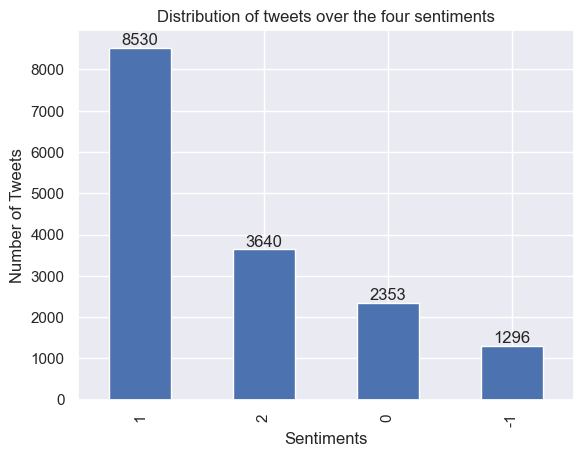

In [52]:
# Counting Number of words
train['sentiment'].value_counts().plot(kind = 'bar')

sentiments = list(seperate_sent(train['sentiment']).keys())
numbers = list(seperate_sent(train['sentiment']).values())

for i, value in enumerate(numbers):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.xlabel('Sentiments')
plt.ylabel('Number of Tweets')
plt.title('Distribution of tweets over the four sentiments')
plt.show()

**Observations:**

   - Seperated the Sentiments and counted the number of tweets in each sentiment.
   - From the graph above it is observed that there are 8530 tweets for sentiment 1, 3640 tweets for sentiment 2, 2353 tweets for sentiment 0 and 1296 tweets for sentiment -1.  

**Distribution of the Number of Words on each tweets**

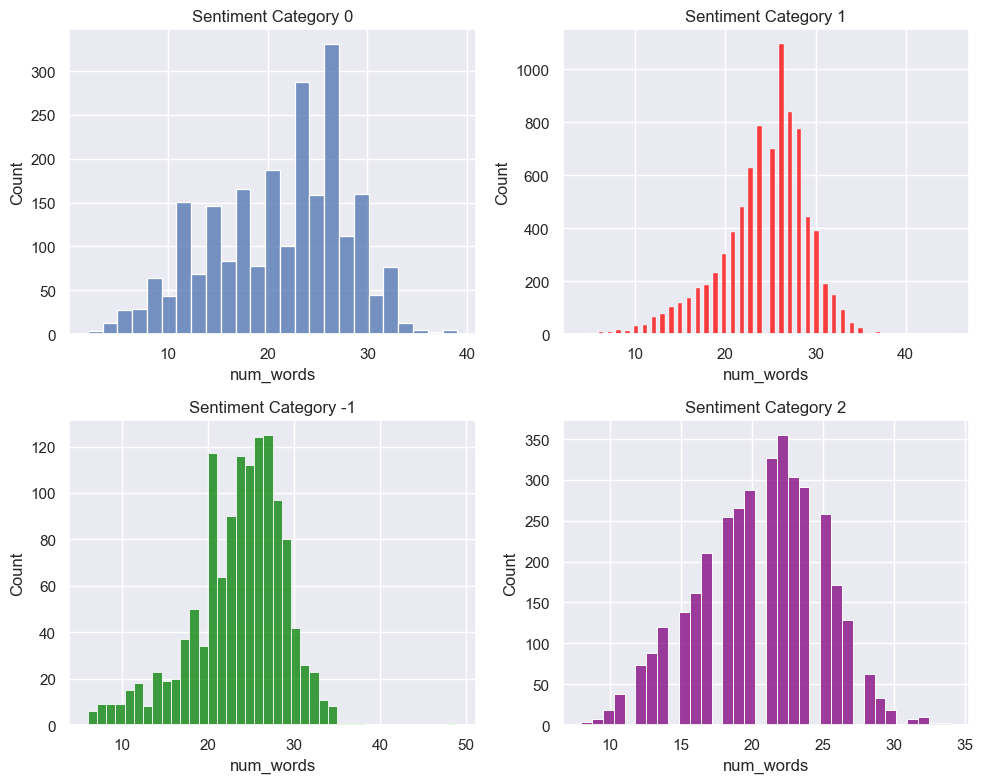

In [53]:
#Creating a number of Words feature
train['num_words'] =train['message'].apply(lambda x:len(nltk.word_tokenize(x)))

# A2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_words'], ax=axes[0, 0])

# Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_words'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_words'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_words'], color='purple', ax=axes[1, 1])

#Titles for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

**Distribution of the Number of Characters on each tweets**

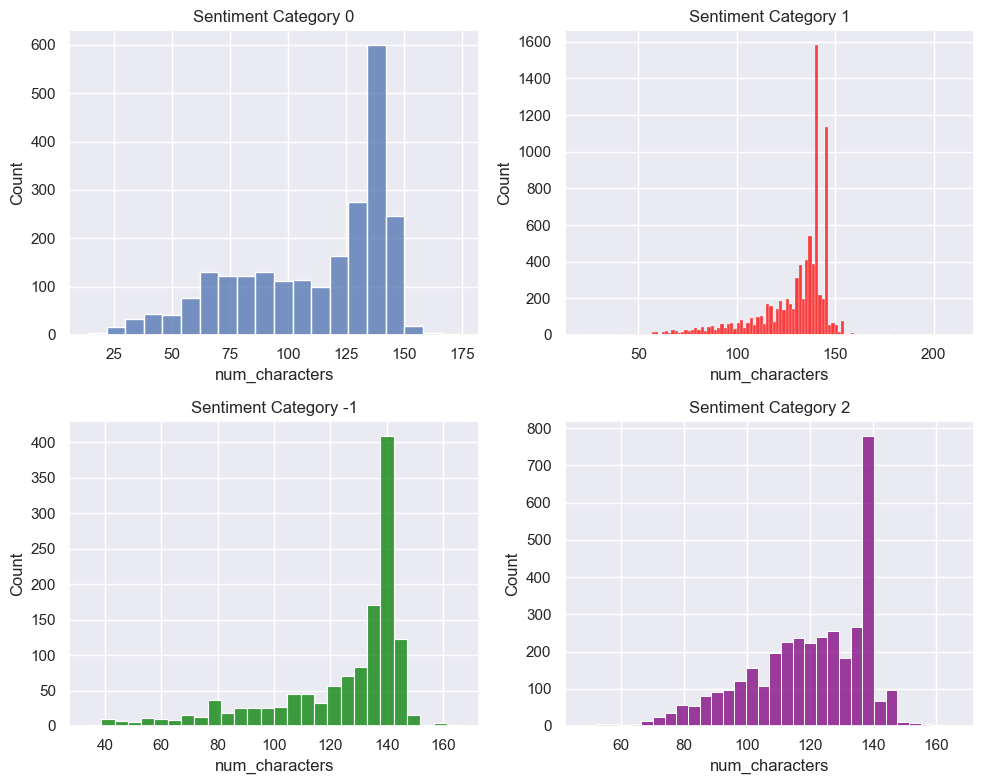

In [54]:
#Creating a number of characters feature
train['num_characters'] = train['message'].apply(len)

#A 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_characters'], ax=axes[0, 0])

#Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_characters'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_characters'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_characters'], color='purple', ax=axes[1, 1])

#The title for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

**Observation:**

**Distribution of the number of characters on each tweets for the four sentiments**

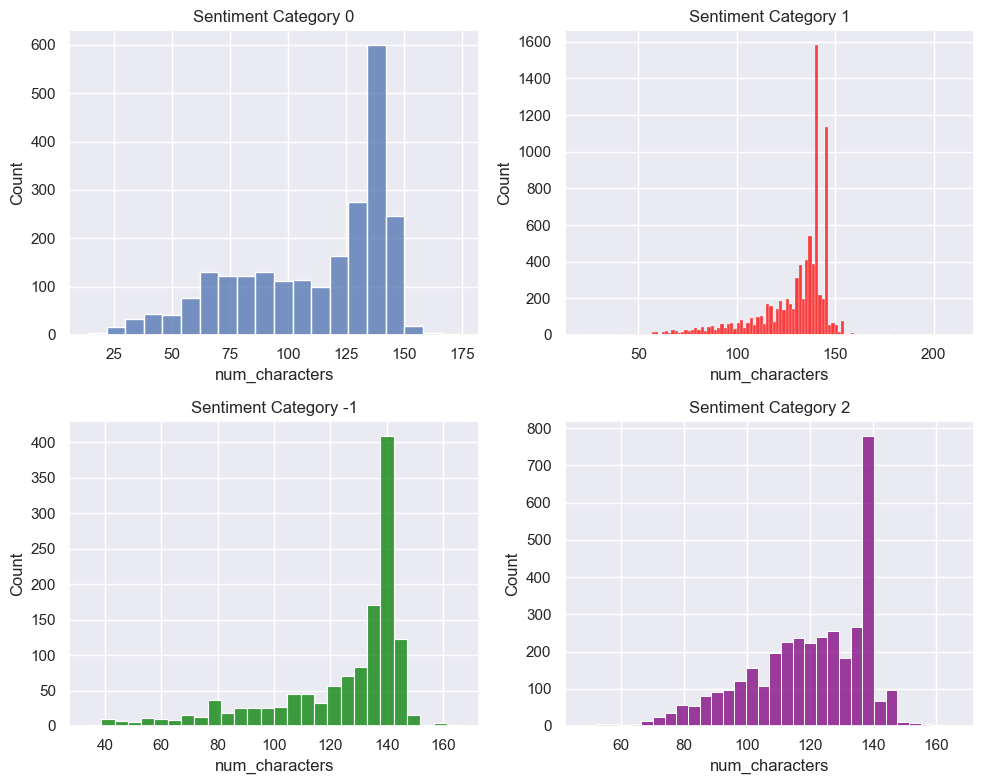

In [55]:
#Creating a number of characters feature
train['num_characters'] = train['message'].apply(len)

#A 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_characters'], ax=axes[0, 0])

#Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_characters'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_characters'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_characters'], color='purple', ax=axes[1, 1])

#The title for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

#Adjusting the spacing between subplots
plt.tight_layout()

#Showing the subplots
plt.show()

**Observation:**

In [56]:
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mapas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mapas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# removing punctuation

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)


In [58]:
train['updated message'] = train['message'].apply(remove_stopwords)

In [59]:
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

In [60]:
# Create and Check if a new column contains messages with no punxtuations
# Make the test lower case
train['updated message'] = train['updated message'].apply(remove_punctuation).str.lower()
train['updated message'].iloc[0]


'polyscimajor epa chief think carbon dioxide main cause global warming and wait what httpstcoyelvcefxkc via mashable'

In [61]:
pro = train.loc[train['sentiment'] == 1, 'updated message']
anti = train.loc[train['sentiment'] == -1, 'updated message']
neutral = train.loc[train['sentiment'] == 0, 'updated message']
news = train.loc[train['sentiment'] == 2, 'updated message']

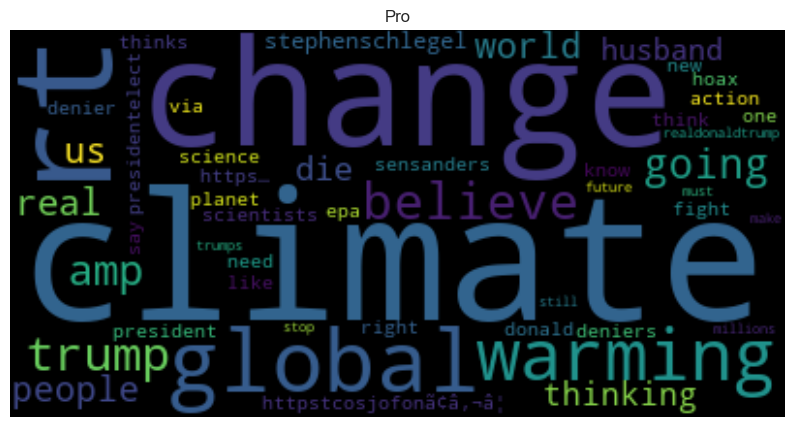

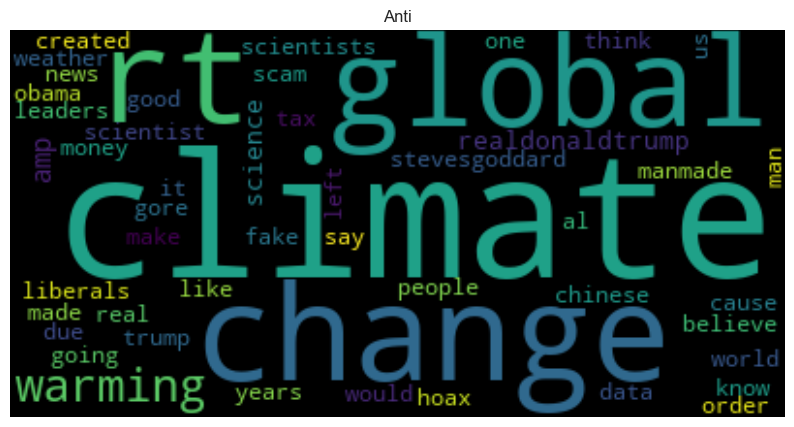

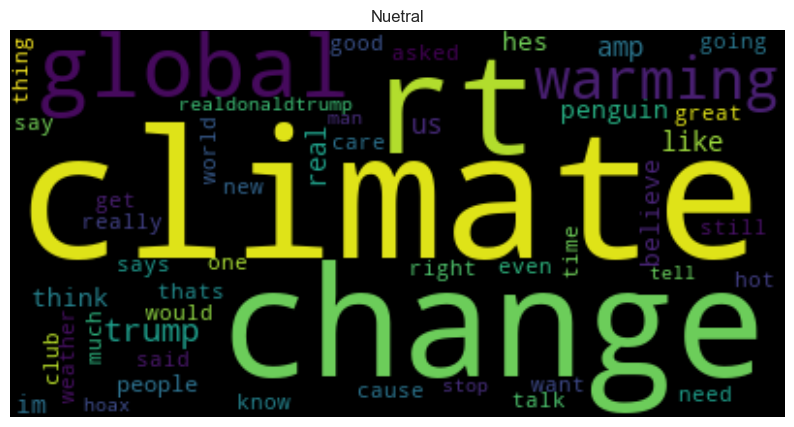

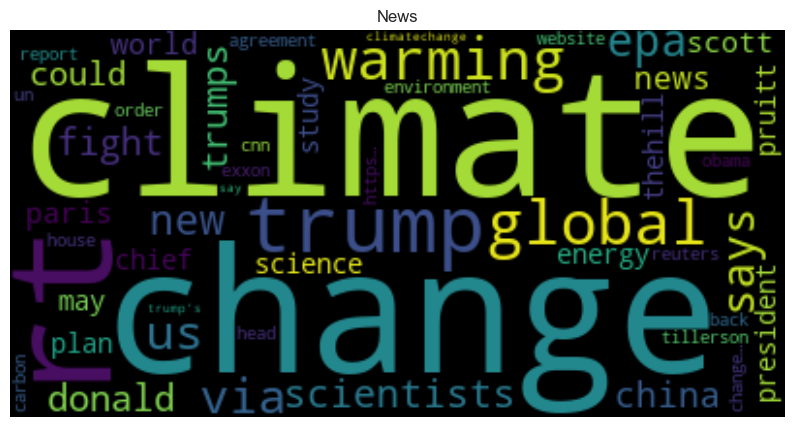

In [65]:

# Calculate word distribution
text = ' '.join(pro)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Pro')
plt.show()


# Calculate word distribution
text = ' '.join(anti)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Anti')
plt.show()


text = ' '.join(neutral)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuetral')
plt.show()


# Calculate word distribution
text = ' '.join(news)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('News')
plt.show()

## Observations:

- From the cloud words above, it is observed that **Climate**, **Change**, **Global** and **Warming** are the most popular words that are used by individuals. 


<a id="six"></a>
## 6. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [ ]:
# View the data after EDA
train.head()

,sentiment,message,tweetid,updated message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researchers say three years act cl...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 pivotal year war clim...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas 2016 racist sexist climate ...


In [ ]:
# remove missing values/ features
# Remove the column message
train = train.drop('message', axis = 1)
train

,sentiment,tweetid,updated message
0,1,625221,polyscimajor epa chief think carbon dioxide ma...
1,1,126103,like lack evidence anthropogenic global warming
2,2,698562,rt rawstory researchers say three years act cl...
3,1,573736,todayinmaker wired 2016 pivotal year war clim...
4,1,466954,rt soynoviodetodas 2016 racist sexist climate ...
...,...,...,...
15814,1,22001,rt ezlusztig took material global warming lgbt...
15815,2,17856,rt washingtonpost climate change could breakin...
15816,0,384248,notiven rt nytimesworld what trump actually be...
15817,-1,819732,rt sara8smiles hey liberals climate change cra...


In [ ]:
# create new features
Pro = train[train['sentiment'] == 1]
Anti = train[train['sentiment'] == -1]
Neutral = train[train['sentiment'] == 0]
News = train[train['sentiment'] == 2]

In [ ]:
# engineer existing features
for word in 

<a id="seven"></a>
## 7. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [ ]:
# split data

In [ ]:
# create targets and features dataset

In [ ]:
# create one or more ML models

In [ ]:
# evaluate one or more ML models

<a id="eight"></a>
## 8. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="nine"></a>
## 9. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic

<a id="ten"></a>
## 10. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="eleven"></a>
## 11. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>